# Analysis

In [12]:
import pandas as pd
import plotnine as pn


In [20]:
# Load data

params = [
    # 0, 2, 4, 6, 8, 10, # nosofsky
    0.1, 0.2, 0.5, 0.6, 0.75, 1, 2, 3, 5, 1000 # exp
]

# Learned
dynamic = "reinforcement_learning"
# dynamic = "replicator_dynamic"

# num_trials = 10
num_trials = 100

# similarity = "nosofsky"
# similarity = "exp"
similarity = "exp_normed"

# distortion = "squared_dist"
distortion = "abs_dist"

out = "multirun"
# out = "outputs"

# trajectory = True
trajectory = False


#############################################################################
# Below three saved in outputs, not multirun

# Pareto frontier
curve_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion={distortion}/curve_points.csv"

# Counterpart points
counterpart_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion={distortion}/counterpart_points.csv"

# Explored hypothetical systems
sampled_fn = f"/Users/nathanielimel/lps/projects/rdsg/outputs/states=10/signals=10/distortion={distortion}/sampled_points.csv"

#############################################################################
# Typically saved in multirun
# Simulation points
param_fns = {
    f"{float(param)}":f"/Users/nathanielimel/lps/projects/rdsg/{out}/states=10/signals=10/distortion={distortion}/similarity={similarity}/dynamics={dynamic}/num_trials={num_trials}/sim_param={param}/simulation_points.csv"
    for param in params
}



In [21]:
# load dataframes
curve_data = pd.read_csv(curve_fn)
counterpart_data = pd.read_csv(counterpart_fn)
sampled_data = pd.read_csv(sampled_fn)

simulation_dataframes = {
    k: pd.read_csv(param_fns[k]) for k in param_fns
}

In [23]:
param_name = {"exp": "beta", "exp_normed": "beta", "nosofsky": "alpha"}[similarity]

# combine simulation dataframes
for key in simulation_dataframes:
    df = simulation_dataframes[key]
    df[param_name] = key # use string for category

sim_data = pd.concat(simulation_dataframes.values())
sim_data

,rate,distortion,beta
0,0.055229,2.764462,0.1
1,0.058586,2.713649,0.1
2,0.038563,2.803273,0.1
3,0.044240,2.795370,0.1
4,0.063293,2.703890,0.1
...,...,...,...
95,3.076906,0.217921,1000.0
96,3.064988,0.220866,1000.0
97,3.283479,0.010796,1000.0
98,3.094638,0.605175,1000.0


In [24]:
sim_data[param_name] = sim_data[param_name].astype(float)
sim_data[param_name] = sim_data[param_name].astype(str)
counterpart_data[param_name] = counterpart_data[param_name].astype(float)
counterpart_data[param_name] = counterpart_data[param_name].astype(str)

sim_data

,rate,distortion,beta
0,0.055229,2.764462,0.1
1,0.058586,2.713649,0.1
2,0.038563,2.803273,0.1
3,0.044240,2.795370,0.1
4,0.063293,2.703890,0.1
...,...,...,...
95,3.076906,0.217921,1000.0
96,3.064988,0.220866,1000.0
97,3.283479,0.010796,1000.0
98,3.094638,0.605175,1000.0


In [25]:
# plot each language, with a unique color for each gamma

# hard to clean this up with pd.Categorical
if param_name == "alpha":
    counterpart_data = counterpart_data.assign(
            alpha=pd.Categorical(
                counterpart_data["alpha"], 
                categories=[g for g in simulation_dataframes.keys()]
            )
        )

    sim_data = sim_data.assign(
            alpha=pd.Categorical(
                sim_data["alpha"], 
                categories=[g for g in simulation_dataframes.keys()]
            )
        )
else:
    counterpart_data = counterpart_data.assign(
            beta=pd.Categorical(
                counterpart_data["beta"], 
                categories=[g for g in simulation_dataframes.keys()]
            )
        )

    sim_data = sim_data.assign(
            beta=pd.Categorical(
                sim_data["beta"], 
                categories=[g for g in simulation_dataframes.keys()]
            )
        )


# Language keys
sim_data["language"] = {"reinforcement_learning": "learned", "replicator_dynamic": "evolved"}[dynamic]
sampled_data["language"] = "hypothetical"
counterpart_data["language"] = "optimal counterpart"
all_data = pd.concat([counterpart_data, sim_data])

# Trajectory keys
if trajectory:
    sim_data["time step"] = sim_data["round"]

counterpart_data


,rate,distortion,beta,language
0,0.002929,2.477034,0.1,optimal counterpart
1,0.016390,2.422780,0.2,optimal counterpart
2,0.491750,1.501507,0.5,optimal counterpart
3,0.663292,1.284500,0.6,optimal counterpart
4,0.904282,1.036575,0.75,optimal counterpart
5,1.281079,0.734408,1.0,optimal counterpart
6,2.265770,0.244407,2.0,optimal counterpart
7,2.806212,0.089341,3.0,optimal counterpart
8,3.217011,0.012120,5.0,optimal counterpart
9,3.321928,0.000000,1000.0,optimal counterpart


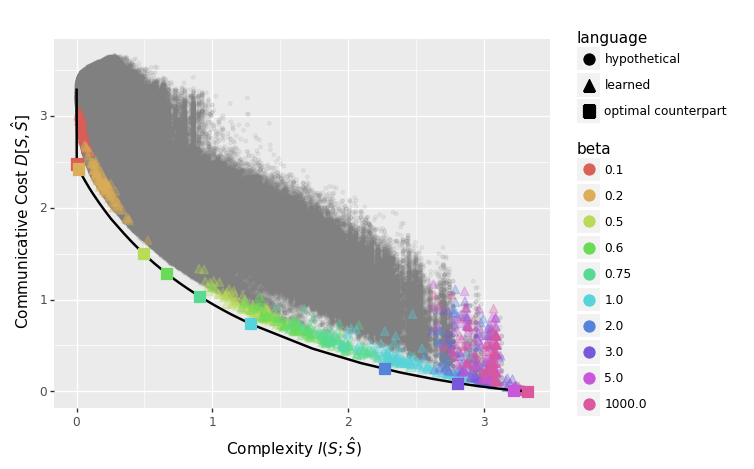

In [26]:
plot = (
    # Set data and the axes
    pn.ggplot(
        data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  
    + pn.geom_point(  # sampled langs
        sampled_data,
        pn.aes(shape="language"),
        color="gray",
        size=1,
        alpha=0.1,
    )        
    + pn.geom_jitter( # simulation langs
        data=sim_data,
        mapping=pn.aes(
            color=param_name, 
            shape="language",
            ),
        alpha=0.3,
        size=3,
        # height=0.1,
    )
    + pn.geom_line(size=1) # pareto data       
    + pn.geom_point( # theoretical bound langs last
        data=counterpart_data,
        mapping=pn.aes(
            color=param_name,
            shape="language",
            ),
        size=4,
    )    
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost $D[S, \hat{S}]$")
)
print(plot)

In [27]:
# Save plot (will overwrite!)

plot_save_dir = f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/distortion={distortion}/similarity={similarity}/dynamics={dynamic}/num_trials={num_trials}"
fn = plot_save_dir + f"/multiple_{param_name}.png"
plot.save(filename=fn, width=10, height=10, dpi=300)
print(fn)

/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 10 in image.
/Users/nathanielimel/miniforge3/envs/rdsg/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: /Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/similarity=exp_normed/distortion=abs_dist/dynamics=reinforcement_learning/num_trials=100/multiple_beta.png


KeyboardInterrupt: 

## Plot trajectories

In [ ]:
# Load data
mean_traj_fns = {
    key: val.replace("simulation_points", "mean_points") for key, val in param_fns.items()
}

mean_traj_dataframes = {
    k: pd.read_csv(mean_traj_fns[k]) for k in mean_traj_fns
}

# combine simulation dataframes
for key in mean_traj_dataframes:
    df = mean_traj_dataframes[key]
    df["alpha"] = key # use string for category

mean_traj_data = pd.concat(mean_traj_dataframes.values())
mean_traj_data = mean_traj_data.dropna() # unnecessary if all files were trajectories
mean_traj_data

In [ ]:
# Plot trajectories, one for each alpha
mean_traj_data = mean_traj_data.assign(
    alpha=pd.Categorical(
        mean_traj_data["alpha"],
        categories=[g for g in simulation_dataframes.keys()]
    )
)

mean_traj_data["language"] = {"reinforcement_learning": "learned", "replicator_dynamic": "evolved"}[dynamic]



In [ ]:
plot = (
    # Set data and the axes
    pn.ggplot(
            data=curve_data, mapping=pn.aes(x="rate", y="distortion")
    )  # pareto data    
    + pn.geom_point(  # sampled langs
        sampled_data,
        pn.aes(shape="language"),
        color="gray",
        # shape="o",
        size=1,
        alpha=0.2,
    )        
    + pn.geom_line(  # simulation langs
        data=mean_traj_data,
        mapping=pn.aes(color="alpha", shape="language"),
        # shape="o",
        alpha=1.0,
        size=2,
    )
    + pn.geom_line(size=1) # pareto last
    + pn.xlab("Complexity $I(S;\hat{S})$")
    + pn.ylab("Communicative Cost $D[S, \hat{S}]$")
)
print(plot)

In [ ]:
# # Save plot (will overwrite!)

# plot_save_dir = f"/Users/nathanielimel/lps/projects/rdsg/multirun/states=10/signals=10/similarity=nosofsky/distortion=squared_dist/dynamics={dynamic}/num_trials={num_trials}"
# fn = plot_save_dir + "/alpha_trajectories.png"
# plot.save(filename=fn, width=10, height=10, dpi=300)